## Import code

In [2]:
%load_ext autoreload
%autoreload 2 
# Autoreloads packages when changes are detected

# If pulp or gurobi are not installed, uncomment the following lines to install them
#! pip install pulp
#! pip install gurobipy

from src.Data import * # Class containing the data
from src.Assignment import * # Class containing an assignment
from src.Model import * # Class containing a Pulp model used for optimization
from src.ModelColumnGen import * # Class containing Pulp model that optimizes using column generation
from src.ModelFracStable import * # Class containing a Pulp model for finding an fractionally stable stochastic improvement
from src.ModelHeuristicLP import * # Class containing heuristic that will use generated weakly stable matchings as an input
from src.DataGen import * # Generate student preferences and school priorities
from src.DataGenEE import * # Generate data according to the method by Erdil & Ergin (2008)
from src.EADAM import * # EADAM implementation
from src.DA_STB import * # Generate DA assignment with single tie-breaking (STB)
from src.ErdilErgin import * # Erdil & Ergil their implementation of Stable Improvement Cycles algorithm + alternative implementation DA
from src.SICs import * # Adaptation of SICs algorithm to our code
from src.Simulations import * # Run solution methods for multiple data instances
from src.SimulationsEvaluate import * # Functions that evaluate simulation results

from ReadData.Estonia.Estonia import * # Read Estonian data

import pickle # to export data



## Column generation formulation

In [7]:
# Generate random data
parameters = DataGenParam(mean_pref = 5, capacity_ratio = 1) # Default parameters, except for mean_pref and capacity_ratio
#MyData = generate_data(n_students=400, n_schools=20, parameters = parameters, name="Test_DataGen", print_data=False, seed = 15)
#[n_students,n_schools,seed] = [40,10,10]
#[n_students,n_schools,seed] = [50,12,10] # Nice, good illustration of results!
#[n_students,n_schools,seed] = [35,15,0] # Clean simple example where EE has no improvement and we have
[n_students,n_schools,seed] = [200,15,10] # Larger. No improvement upon heuristic. But still, heuristic improves quite a lot on EE (93 instead of 90, avg 0.43 instead of 0.38 improvement)
name = str(n_students) + "_" + str(n_schools) + "_" + str(seed)
MyData = generate_data(n_students = n_students, n_schools=n_schools, parameters = parameters, name=name, print_data=False, seed = seed)

In [ ]:
# Print data if desired
print(MyData)

In [ ]:
# Generate the assignment from DA with Single Tie-Breaking with n_iter samples
n_iter = 400
bool_SIC = False # Run SICs immediately?
A = DA_STB(MyData, n_iter, 'GS', bool_SIC, 0, True)

# Find Stable improvement cycles à la Erdil and Ergin (2008)
A_SIC = SIC_all_matchings(MyData, A, True)

In [ ]:
# Solve the formulations
MyModel = ModelColumnGen(MyData, A_SIC, A.assignment, True)
    # Will use matchings in A_SIC to sd_dominate the assignment 'A.assignment' (found by DA)
    
S = MyModel.Solve("TRAD", "GUROBI", print_log=True, time_limit= 20, n_sol_pricing = 10, gap_pricing= 0.1, bool_ColumnGen= True, print_out=True)
#q = MyModel.Solve("STABLE", "GUROBI", True)

In [ ]:
print(S.A.assignment)
print(S.Xdecomp)
print(S.Xdecomp_coeff)

In [ ]:
# Asses and visualize the difference
name_diff = name + '_diff'
diff = Assignment(MyData, S.A.assignment - S.A_DA_prob, name_diff)
diffEE = Assignment(MyData, S.A.assignment - S.A_SIC.assignment)
diff.visualize()
diffEE.visualize()

In [ ]:
# Compare resulting assignment with DA
result = S.A.compare(S.A_DA_prob)
resultEE = S.A_SIC.compare(S.A_DA_prob)
print("Number of improving students EE & us", resultEE['n_students_improving'], result['n_students_improving'])
print("Average improvement rank EE & us", resultEE['average_rank_increase'], result["average_rank_increase"])
print("Median rank improvement", resultEE['median_rank_improvement'], result['median_rank_improvement'])


In [ ]:
# Export data using pickle
A = [0, S]
print(A[1])

# Save to file
with open('pickle_test.pkl', 'wb') as f:
    pickle.dump(A, f)

# Later, load it back
with open('pickle_test.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

print(A[1].A.assignment)


# Column generation Erdil & Ergin data

In [26]:
n_stud = 100
n_schools = 15
pref_list_length = n_schools
alpha_in = 0.5
beta_in = 0.5
seed = 10
MyData = DataGenEE(n_stud, n_schools, alpha_in, beta_in, pref_list_length, True, seed)
print(MyData)

The data instance has the following properties: 

	100 students.
	15 schools. 

 	PREFERENCES:
	0	10 7 3 12 6 4 8 9 13 2 1 0 5 14 11 
	1	4 0 5 9 8 3 13 14 2 1 12 10 7 6 11 
	2	8 4 9 3 12 0 5 1 11 14 10 2 13 7 6 
	3	0 4 10 8 14 1 3 9 13 7 12 6 11 5 2 
	4	3 6 12 13 7 4 10 8 0 5 1 2 11 9 14 
	5	8 3 13 4 12 0 7 14 10 5 11 1 6 9 2 
	6	4 3 0 13 14 8 5 6 9 1 12 7 10 2 11 
	7	12 2 3 9 8 0 5 6 4 7 14 13 1 11 10 
	8	7 9 4 10 1 8 12 0 3 11 6 5 14 2 13 
	9	3 0 4 1 7 9 12 6 10 8 11 13 14 5 2 
	10	4 3 0 8 7 6 9 1 13 12 10 2 14 5 11 
	11	4 3 7 0 9 1 13 12 2 6 8 5 14 10 11 
	12	0 3 4 1 7 8 12 13 6 10 2 9 14 11 5 
	13	3 0 8 11 1 7 5 4 9 12 2 14 10 13 6 
	14	4 0 3 7 10 9 6 1 5 12 13 8 14 11 2 
	15	8 0 4 6 3 5 11 13 1 9 14 7 2 10 12 
	16	8 5 9 3 0 7 12 1 11 4 6 13 2 14 10 
	17	3 0 4 14 13 1 12 6 9 8 7 2 5 10 11 
	18	13 4 8 0 7 1 3 12 9 5 2 10 6 11 14 
	19	12 9 3 7 6 4 2 8 13 0 5 10 14 11 1 
	20	9 4 0 3 6 1 8 7 11 12 2 5 13 10 14 
	21	7 6 9 0 12 8 14 13 5 4 3 2 10 1 11 
	22	4 9 2 1 3 5 12 14 0 7 11 13 6 8

In [42]:
# Generate random data
parameters = DataGenParam(mean_pref = 5, capacity_ratio = 1.1) # Default parameters, except for mean_pref and capacity_ratio
#MyData = generate_data(n_students=400, n_schools=20, parameters = parameters, name="Test_DataGen", print_data=False, seed = 15)
#[n_students,n_schools,seed] = [40,10,10]
#[n_students,n_schools,seed] = [50,12,10] # Nice, good illustration of results!
#[n_students,n_schools,seed] = [35,15,0] # Clean simple example where EE has no improvement and we have
[n_students,n_schools,seed] = [100,15,10] # Larger. No improvement upon heuristic. But still, heuristic improves quite a lot on EE (93 instead of 90, avg 0.43 instead of 0.38 improvement)
name = str(n_students) + "_" + str(n_schools) + "_" + str(seed)
MyData = generate_data(n_students = n_students, n_schools=n_schools, parameters = parameters, name=name, print_data=False, seed = seed)
print(MyData)


The data instance has the following properties: 

	100 students.
	15 schools. 

 	PREFERENCES:
	0	14 13 6 3 
	1	13 14 7 
	2	4 14 13 8 12 
	3	7 0 1 9 
	4	4 0 5 13 3 
	5	4 14 1 8 3 12 
	6	0 13 3 12 8 
	7	7 8 6 4 14 
	8	7 8 13 1 3 
	9	14 11 5 13 
	10	8 7 3 11 
	11	5 12 4 11 
	12	8 5 1 3 9 
	13	14 8 1 9 5 
	14	1 7 4 13 
	15	12 4 13 7 14 9 
	16	7 8 9 12 1 
	17	4 7 9 
	18	3 14 4 12 1 
	19	9 3 10 1 
	20	11 3 12 
	21	3 14 8 4 0 
	22	5 14 7 13 
	23	1 5 14 7 
	24	1 12 13 4 9 
	25	14 5 
	26	3 13 8 
	27	9 12 1 4 
	28	12 13 4 8 14 
	29	11 14 12 8 
	30	7 8 9 
	31	8 12 1 
	32	3 11 9 4 
	33	1 4 14 8 3 
	34	1 13 4 
	35	8 7 
	36	9 14 7 1 
	37	12 11 13 0 
	38	14 11 9 10 
	39	9 8 1 11 13 
	40	11 4 8 13 12 
	41	14 8 7 4 
	42	11 1 9 13 
	43	12 8 5 3 6 
	44	1 13 14 6 
	45	1 12 7 
	46	14 11 0 8 
	47	8 13 9 0 
	48	8 14 9 3 0 
	49	12 1 9 14 
	50	13 0 8 14 
	51	6 12 14 5 3 
	52	13 14 7 9 
	53	13 0 9 5 
	54	9 13 3 
	55	1 11 14 4 13 12 
	56	13 9 8 11 12 1 
	57	12 3 9 
	58	8 12 4 
	59	3 11 8 12 4 
	60	8 13 1 9 
	61

In [43]:
# Generate the assignment from DA with Single Tie-Breaking with n_iter samples
n_iter = 1000
bool_SIC = False # Run SICs immediately?
A = DA_STB(MyData, n_iter, 'GS', bool_SIC, 813847339, True)

# Find Stable improvement cycles à la Erdil and Ergin (2008)
A_SIC = SIC_all_matchings(MyData, A, True)

#A_EADAM = EADAM_STB(MyData, n_iter, 813847339, True)
#A_EADAM.statistics(True)

A_SIC.statistics()

#A.visualize()
#A.find_identical_students(True)
A_SIC.stability_test(True)
#MyData.pref_index


Students in ties: 100
Tie-breaking rules needed: 93326215443944152681699238856266700490715968264381621468592963895217599993229915608941463976156518286253697920827223758251185210916864000000000000000000000000
Tie-breaking rules sampled: 1000


Generate DA_STB: 100%|██████████| 1000/1000 [00:26<00:00, 38.11perturb/s]


STATISTICS BEFORE:

Average rank: 1.66158.



Compute SICs for matchings: 100%|██████████| 1000/1000 [00:02<00:00, 478.06matching/s]


STATISTICS AFTER:

Average rank: 1.5424900000000006.

Matching 0: Unstable pair: Student 85 and School 14.
M(85,-1) = 1, M(70, 14) = 1
Matching 0: Unstable pair: Student 92 and School 12.
M(92,-1) = 1, M(15, 12) = 1
Matching 0: Unstable pair: Student 92 and School 12.
M(92,-1) = 1, M(57, 12) = 1
Matching 0: Unstable pair: Student 92 and School 12.
M(92,-1) = 1, M(67, 12) = 1
Matching 1: Unstable pair: Student 57 and School 9.
M(57,-1) = 1, M(74, 9) = 1
Matching 2: Unstable pair: Student 37 and School 12.
M(37,-1) = 1, M(15, 12) = 1
Matching 2: Unstable pair: Student 37 and School 12.
M(37,-1) = 1, M(43, 12) = 1
Matching 2: Unstable pair: Student 37 and School 12.
M(37,-1) = 1, M(57, 12) = 1
Matching 2: Unstable pair: Student 92 and School 12.
M(92,-1) = 1, M(15, 12) = 1
Matching 2: Unstable pair: Student 92 and School 12.
M(92,-1) = 1, M(43, 12) = 1
Matching 2: Unstable pair: Student 92 and School 12.
M(92,-1) = 1, M(57, 12) = 1
Matching 4: Unstable pair: Student 85 and School 14.
M(85

In [10]:
stability_test_single_matching(MyData, A_SIC.M_list[29], True)



IndexError: list index out of range

In [17]:
# Remove all matchings in the set of matchings
A_SIC.M_set = set()

In [50]:
# Solve the formulations
bool_identical_students= False
bool_punish_unassigned= False
MyModel = ModelColumnGen(MyData, A_SIC, A.assignment, bool_identical_students, bool_punish_unassigned, True)
    # Will use matchings in A_SIC to sd_dominate the assignment 'A.assignment' (found by DA)

S = MyModel.Solve("CUTOFF", "GUROBI", print_log=True, time_limit= 1800, n_sol_pricing= 1, n_sol_pricingMinRank=500, gap_solutionpool_pricing=1.5, MIPGap=0.2, bool_ColumnGen=False, bool_supercolumn= True, print_out=True)


Master: add decision variables: 100%|██████████| 1000/1000 [00:02<00:00, 400.55var/s]



Average rank DA : 1.66158.


Average rank warm start solution : 1.5424900000000006.


Number of matchings: 1000

ITERATION: 1

 ****** MASTER ****** 

Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Xeon(R) W-2123 CPU @ 3.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 436 rows, 1000 columns and 369405 nonzeros (Min)
Model fingerprint: 0xcdc0cf23
Model has 1000 linear objective coefficients
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-03, 1e+00]
Presolve removed 339 rows and 0 columns
Presolve time: 0.06s
Presolved: 97 rows, 1000 columns, 69370 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 4.648e+03
 Factor NZ  : 4.753e+03
 Factor Ops :

In [30]:
# Check stability
M_list = []
for m in S.Xdecomp:
    M_list.append(m)
A_test = Assignment(MyData, S.A.assignment, M_list)
A_test.stability_test(True)

Matching 33: Unstable pair: Student 57 and School 8.
M(57,5) = 1, M(24, 8) = 1
Matching 33: Unstable pair: Student 57 and School 8.
M(57,5) = 1, M(27, 8) = 1
Matching 168: Unstable pair: Student 85 and School 8.
M(85,1) = 1, M(58, 8) = 1
Matching 168: Unstable pair: Student 85 and School 8.
M(85,1) = 1, M(70, 8) = 1
Matching 250: Unstable pair: Student 87 and School 8.
M(87,6) = 1, M(38, 8) = 1
Matching 295: Unstable pair: Student 87 and School 8.
M(87,10) = 1, M(41, 8) = 1
Matching 295: Unstable pair: Student 87 and School 8.
M(87,10) = 1, M(70, 8) = 1
Matching 502: Unstable pair: Student 82 and School 7.
M(82,10) = 1, M(25, 7) = 1
Matching 502: Unstable pair: Student 82 and School 7.
M(82,10) = 1, M(44, 7) = 1
Matching 502: Unstable pair: Student 82 and School 7.
M(82,10) = 1, M(49, 7) = 1
Matching 502: Unstable pair: Student 82 and School 7.
M(82,10) = 1, M(52, 7) = 1
Matching 520: Unstable pair: Student 31 and School 8.
M(31,6) = 1, M(5, 8) = 1
Matching 520: Unstable pair: Student 

In [48]:
# Sanity check: is column generation better than dumbly sampling new matchings?

# Solve the formulations
bool_identical_students= False
bool_punish_unassigned= False
MyModel2 = ModelColumnGen(MyData, A_SIC, A.assignment, bool_identical_students, bool_punish_unassigned, True)
    # Will use matchings in A_SIC to sd_dominate the assignment 'A.assignment' (found by DA)

#S = MyModel.Solve("CUTOFF", "GUROBI", print_log=True, time_limit= 10800, n_sol_pricing= 10000, gap_solutionpool_pricing=0.8, MIPGap=0.5, bool_ColumnGen=False, bool_supercolumn= True, print_out=True)

# Seed not properly controled below
for i in range(1):
    print("\n\n\n@@@@@@@@@ Iteration", i, "@@@@@@@@@\n\n")
    n_generated = 2000
    print("Generate another", n_generated, "matchings")

    A_extra = DA_STB(MyData, n_generated, 'EE', bool_SIC, 5 + 10*n_generated, True)

    # Find Stable improvement cycles à la Erdil and Ergin (2008)
    A_SIC_extra = SIC_all_matchings(MyData, A_extra, True)
    A_SIC_M_list =np.array(list(A_SIC_extra.M_set))

    # Add matchings in A_SIC_extra to model
    for m in tqdm(range(len(A_SIC_M_list)), desc='Master: add decision variables', unit='var', disable= not True):
        #print(self.M[m])
        MyModel2.M_list.append(A_SIC_M_list[m])
        MyModel2.nr_matchings =MyModel2.nr_matchings + 1
        MyModel2.N_MATCH = range(MyModel2.nr_matchings)
        MyModel2.add_matching(A_SIC_M_list[m], len(MyModel2.w), False)
        

        
    S2 = MyModel2.Solve("CUTOFF", "GUROBI", print_log=True, time_limit= 10800, n_sol_pricing= 10000, n_sol_pricingMinRank= 500, gap_solutionpool_pricing=0.8, MIPGap=0.5, bool_ColumnGen=False, bool_supercolumn= True, print_out=True)


#S = MyModel.Solve("TRAD", "GUROBI", print_log=True, time_limit= 600, n_sol_pricing = 100, gap_solutionpool_pricing= 0.2, MIPGap = 0.1, bool_ColumnGen= True, print_out=True)
#q = MyModel.Solve("STABLE", "GUROBI", True)

Master: add decision variables: 100%|██████████| 1000/1000 [00:02<00:00, 416.65var/s]





@@@@@@@@@ Iteration 0 @@@@@@@@@


Generate another 2000 matchings
Students in ties: 100
Tie-breaking rules needed: 93326215443944152681699238856266700490715968264381621468592963895217599993229915608941463976156518286253697920827223758251185210916864000000000000000000000000
Tie-breaking rules sampled: 2000


Generate DA_STB: 100%|██████████| 2000/2000 [00:42<00:00, 47.54perturb/s]


STATISTICS BEFORE:

Average rank: 1.6622349999999988.



Compute SICs for matchings: 100%|██████████| 2000/2000 [00:03<00:00, 577.54matching/s]


STATISTICS AFTER:

Average rank: 1.544874999999943.



Master: add decision variables: 100%|██████████| 1999/1999 [00:05<00:00, 386.85var/s]



Average rank DA : 1.66158.


Average rank warm start solution : 1.5424900000000006.


Number of matchings: 2999

ITERATION: 1

 ****** MASTER ****** 

Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Xeon(R) W-2123 CPU @ 3.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 436 rows, 2999 columns and 1107906 nonzeros (Min)
Model fingerprint: 0x81f5304f
Model has 2999 linear objective coefficients
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-03, 1e+00]
Presolve removed 335 rows and 0 columns
Presolve time: 0.24s
Presolved: 101 rows, 2999 columns, 217965 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 5.047e+03
 Factor NZ  : 5.151e+03 (roughly 1

In [51]:
MyModel.print_dual_values()

for m in range(len(A_SIC_M_list)):
    if S2.Xdecomp_coeff[len(MyModel.w) + m] > 0:
        print("Matching", m, "with coeff", S2.Xdecomp_coeff[len(MyModel.w) + m], "\n\tand pricing objective (after first iteration 1000 matchings)")#, MyModel.get_pricing_objective_of_matching(A_SIC_M_list[m], False))
        A_dummy = Assignment(MyData, A_SIC_M_list[m])
        print("\tand average rank", A_dummy.statistics())
        stability_test_single_matching(MyData, A_SIC_M_list[m], True)   
#print(A_SIC_M_list[1523])
#A_evaluate = Assignment(MyData, A_SIC_M_list[1523])
#A_evaluate.statistics(True)

Dual  Mu_0_13 : 0.10693305739075233
Dual  Mu_3_7 : 0.03746079758019749
Dual  Mu_4_0 : 0.10220647934410754
Dual  Mu_10_8 : 0.051063440261084676
Dual  Mu_17_9 : 0.0659611557749013
Dual  Mu_18_1 : 0.09989572554326265
Dual  Mu_19_9 : 0.0215123776168058
Dual  Mu_19_3 : 0.09303669505691539
Dual  Mu_34_1 : 0.0045156411685085
Dual  Mu_35_7 : 0.03578205842553277
Dual  Mu_37_0 : 0.11634880203772954
Dual  Mu_41_8 : 0.05893417177426016
Dual  Mu_41_4 : 0.09699116453076309
Dual  Mu_43_8 : 0.06852423784128106
Dual  Mu_44_13 : 0.09548435883149081
Dual  Mu_46_0 : 0.006615458091224852
Dual  Mu_46_8 : 0.1286603518267864
Dual  Mu_47_13 : 0.10688291013292915
Dual  Mu_52_14 : 0.06854413754675992
Dual  Mu_53_9 : 0.09718618164450883
Dual  Mu_53_5 : 0.0023386133885210797
Dual  Mu_55_13 : 0.15359945872800898
Dual  Mu_57_9 : 0.11819629069490038
Dual  Mu_63_4 : 0.1091594364403477
Dual  Mu_66_8 : 0.139188092016239
Dual  Mu_67_3 : 0.0915688927803808
Dual  Mu_68_13 : 0.0261092095837018
Dual  Mu_70_9 : 0.042121308604

In [ ]:
A_SIC_M_list =np.array(list(A_SIC_extra.M_set))

# Add matchings in A_SIC_extra to model
for m in tqdm(range(len(A_SIC_M_list)), desc='Master: add decision variables', unit='var', disable= not True):
    #print(self.M[m])
    MyModel.add_matching(A_SIC_M_list[m], len(MyModel.w), False)
    MyModel.nr_matchings = MyModel.nr_matchings + 1
    
S = MyModel.Solve("CUTOFF", "GUROBI", print_log=True, time_limit= 10800, n_sol_pricing= 10000, gap_solutionpool_pricing=0.8, MIPGap=0.5, bool_ColumnGen=False, bool_supercolumn= True, print_out=True)


Master: add decision variables: 100%|██████████| 70/70 [00:00<00:00, 1422.02var/s]


Average rank DA : 2.2663999999999995.


Average rank warm start solution : 2.058800000000002.




ValueError: Invalid value: 'STABLE'. Allowed values are: ['TRAD', 'CUTOFF']

In [18]:
print(S.Xdecomp)
print(S.Xdecomp_coeff)

[array([[1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.]]), array([[0., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.]]), array([[0., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.]]), array([[0., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.]]), array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 

In [13]:
#print(len(S.Xdecomp))
#print(len(MyModel.w))
#print(A_EADAM.statistics())
print(S.A.statistics())
#A_EADAM.visualize()
#S.A.visualize()
S.A.compare(A.assignment, True)
#print(S.avg_ranks)

2.3196875
Number of improving studentss 8
Average rank improvement 0.054937499999999834
Median rank improvement 0.030749999999999944


{'students_improving': [True, True, True, True, True, True, True, True],
 'n_students_improving': 8,
 'rank_increase_by_stud': [np.float64(0.1463000000000001),
  np.float64(-0.11990000000000034),
  np.float64(-0.09810000000000008),
  np.float64(0.26160000000000005),
  np.float64(0.22519999999999962),
  np.float64(0.0506000000000002),
  np.float64(-0.03710000000000058),
  np.float64(0.010899999999999688)],
 'average_rank_increase': np.float64(0.054937499999999834),
 'median_rank_improvement': np.float64(0.030749999999999944)}

In [ ]:
# Compare resulting assignment with DA
result = S.A.compare(S.A_DA_prob)
resultEE = S.A_SIC.compare(S.A_DA_prob)
print(resultEE)
print(result)
print("Number of improving students EE & us", resultEE['n_students_improving'], result['n_students_improving'])
print("Average improvement rank EE & us", resultEE['average_rank_increase'], result["average_rank_increase"])
print("Median rank improvement", resultEE['median_rank_improvement'], result['median_rank_improvement'])


{'students_improving': [False, False, False, False, False, False, False], 'n_students_improving': 0, 'rank_increase_by_stud': [0, 0, 0, 0, 0, 0, 0], 'average_rank_increase': 0, 'median_rank_improvement': 0}
{'students_improving': [False, False, False, False, False, False, False], 'n_students_improving': 0, 'rank_increase_by_stud': [0, 0, 0, 0, 0, 0, 0], 'average_rank_increase': 0, 'median_rank_improvement': 0}
Number of improving students EE & us 0 0
Average improvement rank EE & us 0 0
Median rank improvement 0 0


In [ ]:
# # Asses and visualize the difference
# name_diff = MyData.file_name + '_diff'
# diff = Assignment(MyData, S.A.assignment - S.A_DA_prob, name_diff)
# diffEE = Assignment(MyData, S.A.assignment - S.A_SIC.assignment)
# diff.visualize() # Difference compared to DA
# diffEE.visualize() # Difference compared to EE

# Initial IP data Erdil & Ergin

In [ ]:
n_stud = 15
n_schools = 6
pref_list_length = n_schools
alpha_in = 0.75
beta_in = 0.5
seed = 813847339
MyData = DataGenEE(n_stud, n_schools, alpha_in, beta_in, pref_list_length, True, seed)
print(MyData)

The data instance has the following properties: 

	15 students.
	6 schools. 

 	PREFERENCES:
	0	1 0 4 2 3 5 
	1	4 1 0 2 5 3 
	2	0 1 4 2 5 3 
	3	1 0 4 2 5 3 
	4	0 4 1 2 3 5 
	5	4 0 1 2 3 5 
	6	1 0 4 5 2 3 
	7	1 0 4 5 2 3 
	8	1 2 4 0 3 5 
	9	1 0 2 5 4 3 
	10	0 1 4 5 2 3 
	11	0 1 4 3 5 2 
	12	0 1 4 2 3 5 
	13	1 0 2 4 5 3 
	14	0 4 1 2 5 3 


 	CAPACITIES & PRIORITIES:
	0	3	{2 4 5 11 12 14} {0 1 3 6 7 8 9 10 13} 
	1	3	{6 10} {0 1 2 3 4 5 7 8 9 11 12 13 14} 
	2	3	{0 8 13} {1 2 3 4 5 6 7 9 10 11 12 14} 
	3	3	{0 1 2 3 4 5 6 7 8 9 10 11 12 13 14} 
	4	3	1 {0 2 3 4 5 6 7 8 9 10 11 12 13 14} 
	5	3	{3 7 9} {0 1 2 4 5 6 8 10 11 12 13 14} 



Students in ties: 15
Tie-breaking rules needed: 1307674368000
Tie-breaking rules sampled: 1000


Generate DA_STB: 100%|██████████| 1000/1000 [00:01<00:00, 748.17perturb/s]


STATISTICS BEFORE:

Average rank: 2.3716666666666666.



Compute SICs for matchings: 100%|██████████| 645/645 [00:00<00:00, 2653.74matching/s]


STATISTICS AFTER:

Average rank: 2.3716666666666675.



[]

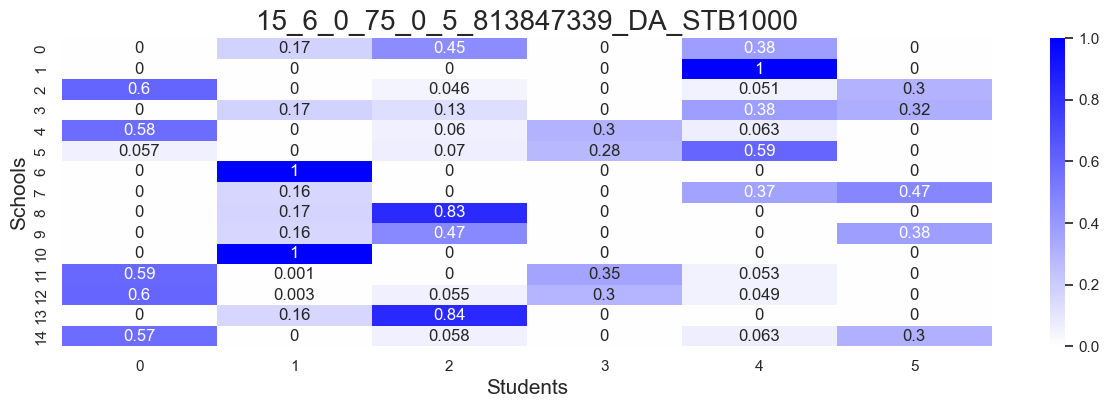

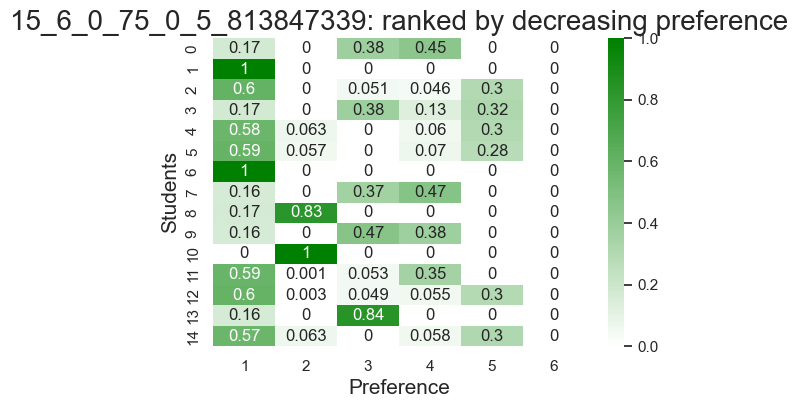

<Figure size 1500x400 with 0 Axes>

In [ ]:
# Generate the assignment from DA with Single Tie-Breaking with n_iter samples
n_iter = 1000
bool_SIC = False # Run SICs immediately?
A = DA_STB(MyData, n_iter, 'EE', bool_SIC, 813847339, True)

# Find Stable improvement cycles à la Erdil and Ergin (2008)
A_SIC = SIC_all_matchings(MyData, A, True)

#A_EADAM = EADAM_STB(MyData, n_iter, 813847339, True)
#A_EADAM.statistics(True)

A.visualize()
A.find_identical_students(True)

In [ ]:
# Solve the formulations
    # 'IMPR_RANK' refers to minimizing the expected rank while ensuring ex-post stability
    # 'STABLE' refers to maximizing the fraction of STABLE matchings in the decomposition
MyModel = Model(MyData, A, True, "CUTOFF", 100)
q = MyModel.Solve("IMPR_RANK", "GUROBI", True)
#q = MyModel.Solve("STABLE", "GUROBI", True)


Average rank before optimization: 2.3716666666666666.


Set parameter Username
Set parameter LicenseID to value 2712222
Academic license - for non-commercial use only - expires 2026-09-23
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 48580 rows, 19390 columns and 160993 nonzeros
Model fingerprint: 0xdc25f5c1
Variable types: 9790 continuous, 9600 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+00]
  Objective range  [7e-02, 4e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-01, 3e+00]
Presolve removed 27914 rows and 8747 columns
Presolve time: 1.39s
Presolved: 20666 rows, 10643 columns, 72283 nonzeros
Variable types: 5448 continuous, 5195 integer (5195 binary)

Root relaxation: objective 1.066667e+00, 6121 iterations, 

KeyboardInterrupt: 

Exception ignored in: 'gurobipy._core.logcallbackstub'
Traceback (most recent call last):
  File "c:\Users\P70096165\AppData\Local\anaconda3\Lib\site-packages\ipykernel\iostream.py", line 655, in write
    def write(self, string: str) -> Optional[int]:  # type:ignore[override]
KeyboardInterrupt: 


     0     0    1.06667    0  410          -    1.06667      -     -   27s


# Simulations

In [ ]:
#n_students_schools = [[100,2],[200,4],[400,8], [800, 16], [1600, 32], [3200, 64]]
n_students_schools = [[200,4],[200,8],[200,12], [200, 16], [200, 20], [200, 24], [200, 28], [200, 32]]

compare_solutions = ["SD_UPON_DA", "SD_UPON_EE", "SD_UPON_EADA"]
    # All options are: ["SD_UPON_DA", "SD_UPON_EE", "SD_UPON_EADA"]

n_iterations_simul = 10
n_match = 1000
time_lim = 60
n_sol_pricing = 20
gap_solutionpool_pricing = 0.15 
MIPGap = 0.05
bool_ColumnGen = False
bool_identical_students = False

seed = 0

#ALPHA_INCREMENT = 0.20
#BETA_INCREMENT = 0.5

#alpha = list(np.arange(0, 1.0, ALPHA_INCREMENT)) + [1.0]
#beta = list(np.arange(0, 1.0, BETA_INCREMENT)) + [1.0]
alpha = [0.25]
beta = [0.5]


S_vector = SimulationCG(compare_solutions, n_students_schools, alpha, beta, n_iterations_simul, n_match, time_lim, seed, n_sol_pricing, gap_solutionpool_pricing, MIPGap, bool_ColumnGen, bool_identical_students, True)


In [ ]:
SimulationsEvaluate("SIM_2025-07-29_131019", False)

## Estonian data

In [ ]:
file_path = "ReadData/Estonia/data_anon.txt" 
MyData = read_dataEstonia(file_path)
print(MyData)

The data instance has the following properties: 

	152 students.
	7 schools. 

 	PREFERENCES:
	1	2 3 6 5 7 1 4 
	2	4 3 6 7 5 2 1 
	3	2 5 3 6 7 1 4 
	4	5 7 2 3 6 1 4 
	5	6 3 5 7 2 1 4 
	6	2 3 5 7 1 6 4 
	7	3 6 2 5 7 1 4 
	8	4 1 2 3 6 7 5 
	9	6 3 2 5 7 1 4 
	10	5 3 2 7 1 6 4 
	11	3 2 5 4 6 7 1 
	12	5 2 1 7 6 3 4 
	13	2 3 5 7 6 1 4 
	14	4 1 3 2 5 7 6 
	15	6 3 2 1 5 4 7 
	16	5 2 7 3 1 6 4 
	17	2 5 3 7 6 1 4 
	18	3 6 2 5 4 1 7 
	19	6 3 2 5 7 1 4 
	20	7 5 2 4 3 6 1 
	21	3 6 2 5 7 1 4 
	22	2 5 7 3 1 4 6 
	23	6 2 5 3 7 1 4 
	24	5 3 2 7 1 6 4 
	25	2 5 3 6 1 7 4 
	26	3 2 5 7 1 6 4 
	27	2 6 3 5 4 7 1 
	28	2 3 4 1 5 6 7 
	29	2 5 3 6 7 4 1 
	30	6 3 4 2 5 7 1 
	31	6 3 2 5 7 1 4 
	32	5 6 3 7 1 4 2 
	33	6 3 5 2 1 7 4 
	34	5 3 2 7 6 1 4 
	35	6 3 2 5 7 1 4 
	36	3 2 5 1 7 6 4 
	37	1 2 4 5 7 6 3 
	38	2 5 3 6 7 1 4 
	39	7 1 2 5 6 3 4 
	40	2 3 1 5 6 4 7 
	41	2 3 6 5 7 1 4 
	42	3 5 7 2 6 1 4 
	43	3 2 5 6 7 1 4 
	44	2 6 3 5 4 1 7 
	45	5 7 3 1 2 6 4 
	46	2 3 6 5 4 1 7 
	47	5 2 3 7 6 4 1 
	48	3 2 5 6 7 1 4 
	49

In [ ]:
# Generate the assignment from DA with Single Tie-Breaking with n_iter samples
n_iter = 1000
bool_SIC = False # Run SICs immediately?
A = DA_STB(MyData, n_iter, 'GS', bool_SIC, 0, True)

# Find Stable improvement cycles à la Erdil and Ergin (2008)
A_SIC = SIC_all_matchings(MyData, A, True)

A_EADAM = EADAM_STB(MyData, n_iter, 0, True)

print(A.assignment)
A.statistics()
A_SIC.statistics()
A_EADAM.statistics()

Students in ties: 152
Tie-breaking rules sampled: 1000


Generate DA_STB: 100%|██████████| 1000/1000 [00:23<00:00, 42.23perturb/s]


STATISTICS BEFORE:

Average rank: 1.8237565789473678.



Compute SICs for matchings: 100%|██████████| 1000/1000 [00:03<00:00, 322.83matching/s]


STATISTICS AFTER:

Average rank: 1.8015394736842112.

Students in ties: 152
Tie-breaking rules sampled: 1000


Generate EADAM_STB: 100%|██████████| 1000/1000 [00:11<00:00, 90.44perturb/s]


[[0.    0.645 0.355 ... 0.    0.    0.   ]
 [0.055 0.    0.    ... 0.    0.    0.   ]
 [0.    0.665 0.095 ... 0.24  0.    0.   ]
 ...
 [0.    0.    0.296 ... 0.    0.704 0.   ]
 [0.    0.    0.    ... 0.    1.    0.   ]
 [0.073 0.    0.    ... 0.    0.    0.   ]]


np.float64(1.79995394736842)

In [ ]:
# Solve the formulations
MyModel = ModelColumnGen(MyData, A_SIC, A.assignment, False, True)
#MyModel = ModelColumnGen(MyData, A_SIC, A_EADAM.assignment, False, True) # Compare to A_EADAM

timeLimit = 360
S = MyModel.Solve("TRAD", "GUROBI", print_log=True, time_limit= timeLimit, n_sol_pricing = 2, gap_solutionpool_pricing = 0.2, MIPGap= 0.1, bool_ColumnGen=True, print_out=True)
#q = MyModel.Solve("STABLE", "GUROBI", True)

Master: add decision variables: 100%|██████████| 1000/1000 [00:11<00:00, 89.16var/s]



Average rank DA : 1.8237565789473678.


Average rank warm start solution : 1.8015394736842112.




c:\Users\P70096165\AppData\Local\anaconda3\Lib\site-packages\pulp\pulp.py:1489: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")
Pricing exclude found matchings: 100%|██████████| 1000/1000 [00:21<00:00, 46.32matchings/s]

Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Set parameter Username
Set parameter LicenseID to value 2712222
Academic license - for non-commercial use only - expires 2026-09-23


Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1059 rows, 1000 columns and 936504 nonzeros
Model fingerprint: 0x416e0f19
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+00]
Presolve removed 898 rows and 0 columns
Presolve time: 0.27s
Presolved: 161 rows, 1000 columns, 108475 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.288e+04
 Factor NZ  : 1.304e+04 (roughly 1 MB of memory)
 Factor Ops : 1.404e+06 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residual
Iter       Primal          Dual         Primal    D

In [ ]:
# Compare resulting assignment with DA
result = S.A.compare(S.A_DA_prob)
resultEE = S.A_SIC.compare(S.A_DA_prob)
print(resultEE)
print(result)
print("Number of improving students EE & us", resultEE['n_students_improving'], result['n_students_improving'])
print("Average improvement rank EE & us", resultEE['average_rank_increase'], result["average_rank_increase"])
print("Median rank improvement", resultEE['median_rank_improvement'], result['median_rank_improvement'])


{'students_improving': [False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, True, True, False, True, True, False, True, True, False, False, False, False, False, True, False, False, False, False, True, False, False, False, True, False, False, False, False, False, True, True, False, True, False, True, False, False, True, True, False, True, False, True, True, True, False, False, False, True, True, False, True, False, False, False, False, True, True, True, True, True, True, False, True, True, True, True, False, True, True, False, True, False, False, True, True, False, True, False, False, True, True, True, False, True, False, False, False, True, False, False, False, True, False, False, True, False, False, False, False, False, True, False, False, False, False, True, True, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False

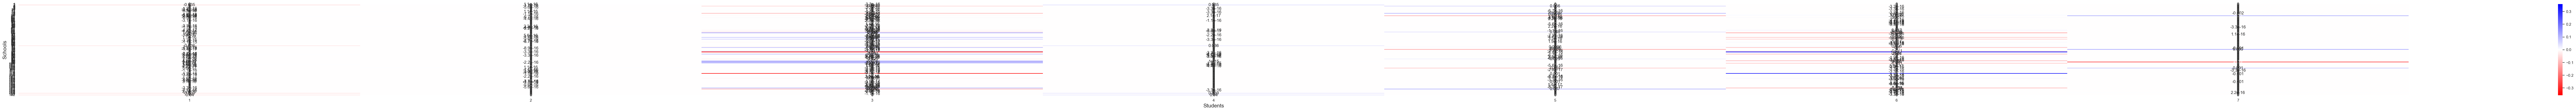

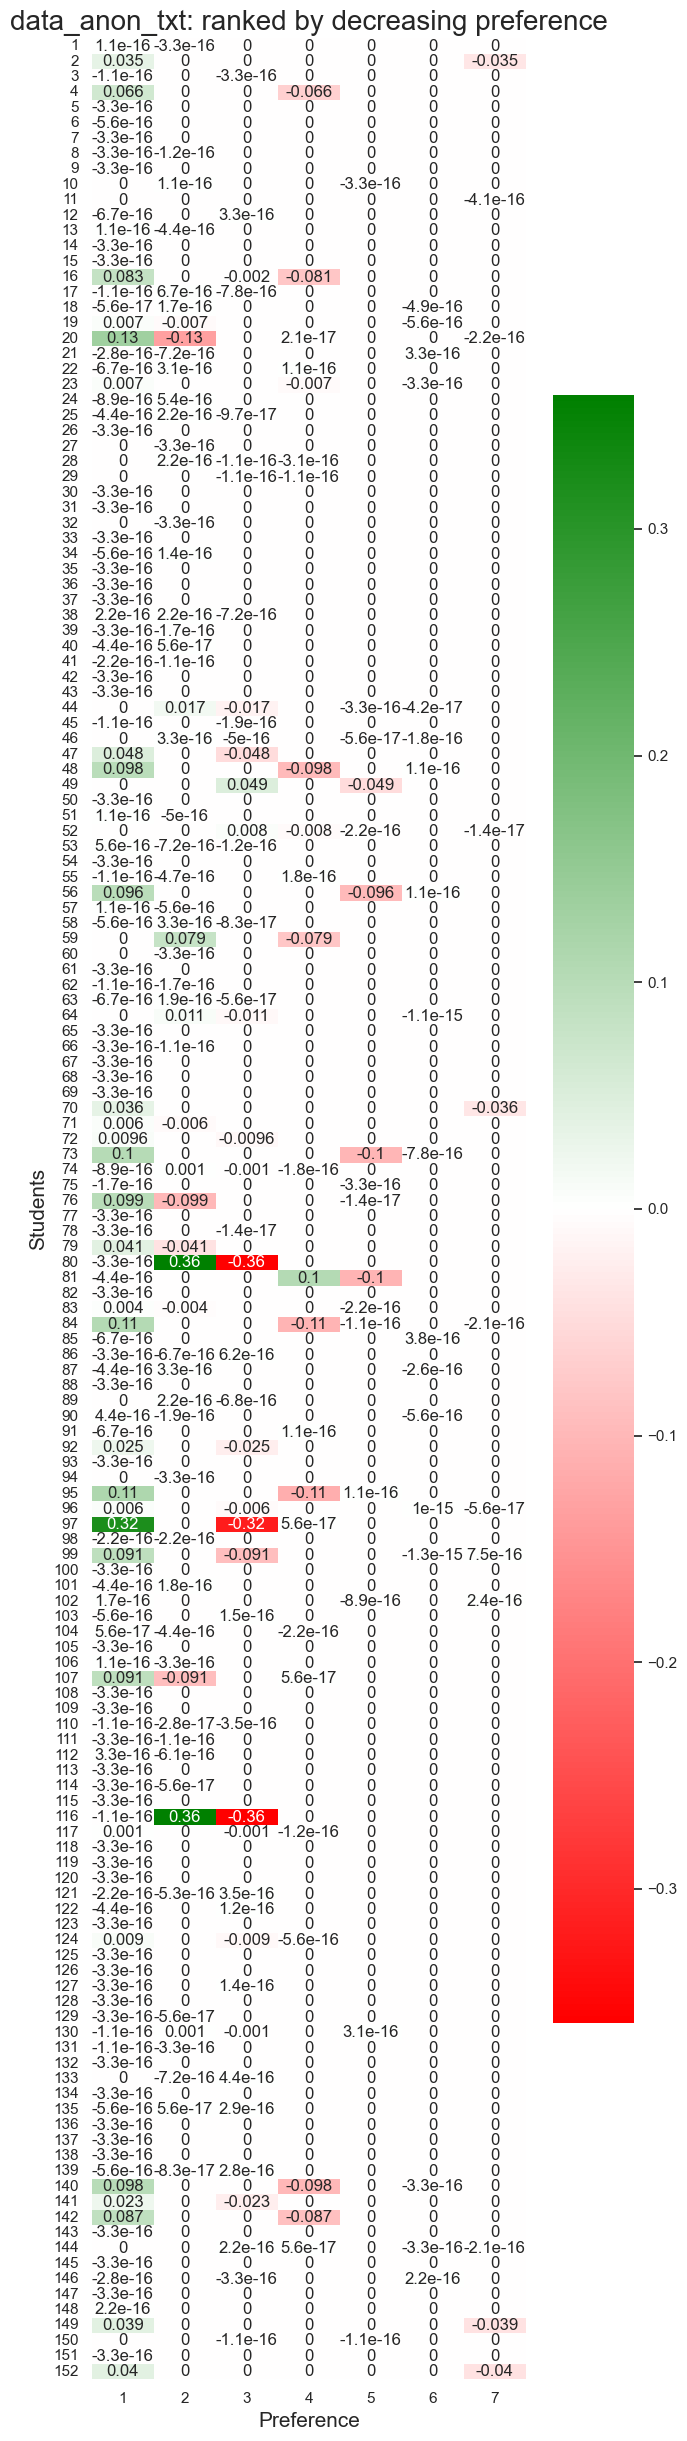

<Figure size 15200x466.667 with 0 Axes>

In [ ]:
A_diff = Assignment(MyData, S.A.assignment - A.assignment)
A_diff.visualize()

In [ ]:
# Generate a second subset of matchings, and test column generation with that
# (10 June 2025: not yet configured for use of warm start)
n_iter = 1000
bool_SIC = True # Run SICs immediately?
B = DA_STB(MyData, n_iter, 'GS', bool_SIC, 1, True)
B_SIC = SIC_all_matchings(MyData, B, True)
A_SIC.M_set = copy.deepcopy(B_SIC.M_set)
MyModel2 = ModelColumnGen(MyData, A_SIC, A.assignment, True)
qq = MyModel2.Solve("TRAD", "GUROBI", print_log=True, print_out=False)


## Run initial IP on generated data
Specify the number of students and schools, and run the models for this data.

In [ ]:
# Generate random data
parameters = DataGenParam(mean_pref = 6, capacity_ratio = 1) # Default parameters, except for mean_pref and capacity_ratio
#MyData = generate_data(n_students=400, n_schools=20, parameters = parameters, name="Test_DataGen", print_data=False, seed = 15)
MyData = generate_data(n_students=1000, n_schools=50, parameters = parameters, name="Test_DataGen_EE_vs_GS", print_data=False, seed = 0)

In [ ]:
# Print data if desired
print(MyData)

In [ ]:
# Generate the assignment from DA with Single Tie-Breaking with n_iter samples
n_iter = 20
bool_SIC = True # Run SICs immediately?
A = DA_STB(MyData, n_iter, 'GS', bool_SIC, 0, True)
print(A.assignment)

In [ ]:
# Solve the formulations
    # 'IMPR_RANK' refers to minimizing the expected rank while ensuring ex-post stability
    # 'STABLE' refers to maximizing the fraction of STABLE matchings in the decomposition
MyModel = Model(MyData, A, True)
q = MyModel.Solve("IMPR_RANK", "GUROBI", True)
#q = MyModel.Solve("STABLE", "GUROBI", True)

In [ ]:
# Print the solution
MyModel.print_solution()

In [ ]:
# Asses and visualize the difference
name_diff = name + '_diff'
diff = Assignment(MyData, q.assignment - A.assignment, name_diff)
diff.visualize()

## Heuristic subset weakly stable matchings
Runs an LP that minimizes the average rank while stochastically dominating the DA assignment with single-tie breaking, and while only using matchings that were used to compute DA probabilities. This is a heuristic.

In [ ]:
# Generate random data
parameters = DataGenParam(mean_pref = 5, capacity_ratio = 1) # Default parameters, except for mean_pref and capacity_ratio
#MyData = generate_data(n_students=400, n_schools=20, parameters = parameters, name="Test_DataGen", print_data=False, seed = 15)
MyData = generate_data(n_students=10, n_schools=4, parameters = parameters, name="500_25", print_data=False, seed = 1)

In [ ]:
# Print data if desired
print(MyData)

In [ ]:
# Generate the assignment from DA with Single Tie-Breaking with n_iter samples
n_iter = 1000
bool_SIC = True # Run SICs immediately?
A = DA_STB(MyData, n_iter, 'GS', bool_SIC, 0, True)
print(A.assignment)

In [ ]:
# Solve the formulations
    # 'IMPR_RANK' refers to minimizing the expected rank while ensuring ex-post stability
MyModel = ModelHeuristicLP(MyData, A, True)
q = MyModel.Solve("IMPR_RANK", "GUROBI", True)
#q = MyModel.Solve("STABLE", "GUROBI", True)

In [ ]:
# Print the solution
MyModel.print_solution()

In [ ]:
print(np.max(q.assignment-A.assignment))

In [ ]:
# Asses and visualize the difference
diff = Assignment(MyData, q.assignment - A.assignment, "40_12_Diff")
diff.visualize()

## Heuristic Fractional stable random matching

In [ ]:
# Solve the formulations
    # 'IMPR_RANK' refers to minimizing the expected rank while ensuring ex-post stability
MyModelFS = ModelFracStable(MyData, A, True)
q = MyModelFS.Solve("IMPR_RANK", "GUROBI", True)
#q = MyModel.Solve("STABLE", "GUROBI", True)

In [ ]:
# FInd decomposition over weakly stable matchings of this fractionally stable matching (if decomposition exists)
MyModelCHECK = Model(MyData, q, True)
q_check = MyModelCHECK.Solve("STABLE", "GUROBI", True)

## Run code manual data
Manually enter data.

In [13]:
# Define preferences of the students
# 'pref[i][k]' contains the position of the k-th ranked school in the preferences.
# We assume the preferences to be strict
# Note that preferences can be strict. We indicate this by a tuple () in the list.

# Example paper
n_stud = 4
n_schools = 4

file_name = "Ex_paper"

# Preferences students
pref = [['1', '3', '4', '2'],
       ['1','4','3','2'],
       # ['1', '4'],
       ['2','3', '4', '1'],
       ['2', '4', '3', '1']]

# Priorities schools
prior = [[('A', 'B'), 'C', 'D'],
        [('C', 'D'), 'A', 'B'],
        ['B', 'D', ('A', 'C')],
        ['A', 'C', ('B', 'D')]]


# Capacities schools
cap = [1,1,1,1]

# Names of students and schools
ID_stud = ["A", "B", "C", "D"]
ID_school = ["1", "2", "3", "4"]

# Also create the random matching upon which we want to improve
p = np.zeros(shape=(n_stud, n_schools))
p[0][0] = 1/2
p[1][0] = 1/2
p[2][1] = 1/2
p[3][1] = 1/2
p[0][2] = 3/8
p[2][2] = 3/8
p[1][3] = 3/8
p[3][3] = 3/8
p[0][3] = 1/8
p[2][3] = 1/8
p[1][2] = 1/8
p[3][2] = 1/8

In [14]:
# Define preferences of the students
# 'pref[i][k]' contains the position of the k-th ranked school in the preferences.
# We assume the preferences to be strict
# Note that preferences can be strict. We indicate this by a tuple () in the list.

# Example paper
n_stud = 8
n_schools = 8

file_name = "Ex_paper_FDA"

# Preferences students
pref = [['1', '3', '4', '2'],
       ['1','4','3','2'],
       # ['1', '4'],
       ['2','4', '3', '1'],
       ['2', '3', '4', '1'],
       ['5', '4', '6'],
       ['7', '3', '8'],
       ['5', '6'],
       ['7', '8']]

# Priorities schools
prior = [[('3', '4'), ('1', '2')],
        [('1', '2'), ('3', '4')],
        ['3', '2', ('1', '6'), '4'],
        ['4', '1', ('2', '5'), '3'],
        [('7', '5')],
        ['7', '5'],
        [('6', '8')],
        ['8', '6']]


# Capacities schools
cap = [1,1,1,1,1,1,1,1]

# Names of students and schools
ID_stud = ["1", "2", "3", "4", "5", "6", "7", "8"]
ID_school = ["1", "2", "3", "4", "5", "6", "7", "8"]


In [15]:
# Generate a data instance (and print it)
MyData = Data(n_stud, n_schools, pref, prior, cap, ID_stud, ID_school, file_name)
print(MyData)
print(MyData.rank_prior)

The data instance has the following properties: 

	8 students.
	8 schools. 

 	PREFERENCES:
	1	1 3 4 2 
	2	1 4 3 2 
	3	2 4 3 1 
	4	2 3 4 1 
	5	5 4 6 
	6	7 3 8 
	7	5 6 
	8	7 8 


 	CAPACITIES & PRIORITIES:
	1	1	{3 4} {1 2} 
	2	1	{1 2} {3 4} 
	3	1	3 2 {1 6} 4 
	4	1	4 1 {2 5} 3 
	5	1	{7 5} 
	6	1	7 5 
	7	1	{6 8} 
	8	1	8 6 

[[ 2.  2.  1.  1. nan nan nan nan]
 [ 1.  1.  2.  2. nan nan nan nan]
 [ 3.  2.  1.  4. nan  3. nan nan]
 [ 2.  3.  4.  1.  3. nan nan nan]
 [nan nan nan nan  1. nan  1. nan]
 [nan nan nan nan  2. nan  1. nan]
 [nan nan nan nan nan  1. nan  1.]
 [nan nan nan nan nan  2. nan  1.]]


In [16]:
# Generate the assignment from DA with Single Tie-Breaking with n_iter samples
n_iter = 10000
bool_SIC = False # Run SICs immediately?
A = DA_STB(MyData, n_iter, 'GS', bool_SIC, 8754, True)

# Find Stable improvement cycles à la Erdil and Ergin (2008)
A_SIC = SIC_all_matchings(MyData, A, True)

A_EADAM = EADAM_STB(MyData, n_iter, 0, True)


print("DA with random tie-breaking\n",A.assignment,"\n")
print("Erdil & Ergin\n",A_SIC.assignment,"\n")
print("EADA\n",A_EADAM.assignment, "\n")
A.statistics()
A_SIC.statistics()
A_EADAM.statistics()

Students in ties: 8
Tie-breaking rules needed: 40320
Tie-breaking rules sampled: 10000


Generate DA_STB: 100%|██████████| 10000/10000 [00:02<00:00, 3452.85perturb/s]


STATISTICS BEFORE:

Average rank: 1.823075.



Compute SICs for matchings: 100%|██████████| 22/22 [00:00<00:00, 5721.75matching/s]


STATISTICS AFTER:

Average rank: 1.747312500000011.

Students in ties: 8
Tie-breaking rules needed: 40320
Tie-breaking rules sampled: 10000


Generate EADAM_STB: 100%|██████████| 10000/10000 [00:04<00:00, 2321.20perturb/s]

DA with random tie-breaking
 [[0.5032 0.0589 0.2864 0.1515 0.     0.     0.     0.    ]
 [0.4968 0.062  0.1552 0.286  0.     0.     0.     0.    ]
 [0.     0.4385 0.4645 0.097  0.     0.     0.     0.    ]
 [0.     0.4406 0.0939 0.4655 0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.5063 0.4937 0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.5085 0.4915]
 [0.     0.     0.     0.     0.4937 0.5063 0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.4915 0.5085]] 

Erdil & Ergin
 [[0.5032 0.     0.3447 0.1521 0.     0.     0.     0.    ]
 [0.4968 0.     0.1228 0.3804 0.     0.     0.     0.    ]
 [0.     0.4385 0.4062 0.1553 0.     0.     0.     0.    ]
 [0.     0.5615 0.1263 0.3122 0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.5063 0.4937 0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.5085 0.4915]
 [0.     0.     0.     0.     0.4937 0.5063 0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.4915 0.5085]] 

EADA
 

np.float64(1.6877875000000002)

In [18]:
# Remove matchings from generated set
# for i in A.M_set:
#    print(i)

    # Remove specific matching
#    M = np.zeros(shape=(MyData.n_stud, MyData.n_schools))
    #M[0][0] = 1
    #M[1][3] = 1
    #M[2][2] = 1
    #M[3][1] = 1
#    M[0][2] = 1
#    M[1][0] = 1
#    M[2][1] = 1
#    M[3][3] = 1
#    remove1=tuple(map(tuple, M))

#A.M_set.remove(remove1)

#print("New")

#for i in A.M_set:
#    print(i)

# Define empty assignment object
A_empty = deepcopy(A)
A_empty.M_set = set()
print(A_empty.M_set)

set()


In [ ]:
# Solve the formulations
MyModel = ModelColumnGen(MyData, A_empty, A.assignment, False, True, True)

S = MyModel.Solve("CUTOFF", "GUROBI", print_log=False, time_limit= 3600, n_sol_pricing= 1, gap_solutionpool_pricing=0, MIPGap=0, bool_ColumnGen=True, bool_supercolumn= True, print_out=True)
                    
#q = MyModel.Solve("STABLE", "GUROBI", True)

Master: add decision variables: 0var [00:00, ?var/s]


Average rank DA : 1.823075.


Average rank warm start solution : 1.823075.





c:\Users\p70096165\AppData\Local\anaconda3\Lib\site-packages\pulp\pulp.py:1489: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


IndexError: list index out of range

In [ ]:
# Print the solution
print(S.A.assignment)
print(S.Xdecomp)
print(S.Xdecomp_coeff)

[[0.5 0.  0.5 0. ]
 [0.5 0.  0.  0.5]
 [0.  0.5 0.5 0. ]
 [0.  0.5 0.  0.5]]
[array([[1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.]]), array([[ 1., -0.,  0., -0.],
       [ 0., -0., -0.,  1.],
       [-0.,  0.,  1., -0.],
       [-0.,  1., -0., -0.]]), array([[-0., -0.,  1., -0.],
       [ 1., -0., -0., -0.],
       [-0.,  1.,  0., -0.],
       [-0.,  0., -0.,  1.]])]
[0.0, 0.5, 0.5]


In [ ]:
# Asses and visualize the difference
diff = Assignment(MyData, q.assignment - p, "Ex_paper_Diff")
diff.visualize()

In [ ]:
tuple([1,2])

# Erdil & Ergin experiments

In [ ]:
# Define preferences of the students
# 'pref[i][k]' contains the position of the k-th ranked school in the preferences.
# We assume the preferences to be strict
# Note that preferences can be strict. We indicate this by a tuple () in the list.

# Example paper
n_stud = 4
n_schools = 4

file_name = "Ex_paper"

# Preferences students
pref = [['1', '3', '4', '2'],
       ['1','4','3','2'],
       # ['1', '4'],
       ['2','3', '4', '1'],
       ['2', '4', '3', '1']]

# Priorities schools
prior = [[('A', 'B'), 'C', 'D'],
        [('C', 'D'), 'A', 'B'],
        ['B', 'D', ('A', 'C')],
        ['A', 'C', ('B', 'D')]]


# Capacities schools
cap = [1,1,1,1]

# Names of students and schools
ID_stud = ["A", "B", "C", "D"]
ID_school = ["1", "2", "3", "4"]

# Also create the random matching upon which we want to improve
p = np.zeros(shape=(n_stud, n_schools))
p[0][0] = 1/2
p[1][0] = 1/2
p[2][1] = 1/2
p[3][1] = 1/2
p[0][2] = 3/8
p[2][2] = 3/8
p[1][3] = 3/8
p[3][3] = 3/8
p[0][3] = 1/8
p[2][3] = 1/8
p[1][2] = 1/8
p[3][2] = 1/8

# Generate a data instance (and print it)
MyData = Data(n_stud, n_schools, pref, prior, cap, ID_stud, ID_school, file_name)
print(MyData)


In [ ]:
# Do tie-breaking
permut = generate_permutations_STB(MyData, 1, seed = 3)

prior_new = generate_strict_prior_from_perturbation(MyData, permut[0])

Data_new_prior = Data(MyData.n_stud, MyData.n_schools, MyData.pref, prior_new, MyData.cap, MyData.ID_stud, MyData.ID_school, MyData.file_name)

# DA code Erdil & Ergin
N = transform_pref_us_to_EE(Data_new_prior)
A = transform_prior_us_to_EE(Data_new_prior)
Q = MyData.cap
result = DA_Erdil_ergin(N,A,Q)
print(result)
print(type(result['proposeoffset']))

M = gale_shapley(Data_new_prior)
print(type(M))
print(M)

M = np.zeros((4,4))
M[0,1] = 1
M[1,2] = 1
M[2,3] = 1
M[3,0] = 1
print(M)
print(M[0,1] == 1)

M_out = SIC(MyData, M, False)
print(M_out)

In [ ]:
bool_SIC = False # Run SICs immediately?
AssignmentGS = DA_STB(MyData, 10, 'GS', bool_SIC, 0)
ASIC = SIC_all_matchings(MyData, AssignmentGS, True)

print(AssignmentGS.assignment)




# EADAM tests

In [ ]:
# Example paper Tang & Yu (2014)
n_stud = 4
n_schools = 4

file_name = "Ex_paper_TangYu"

# Preferences students
pref = [[1, 0],
        [0, 2],
        [0, 1],
        [2, 3]]

# Priorities schools
prior = [[0, 1, 2],
         [2, 0],
         [1, 3],
        [3]]


# Capacities schools
cap = [1,1,1,1]

# Names of students and schools
ID_stud = [0, 1, 2, 3]
ID_school = [0, 1, 2, 3]

# Generate a data instance (and print it)
MyData = Data(n_stud, n_schools, pref, prior, cap, ID_stud, ID_school, file_name)
print(MyData)
consent = [1, 1, 1, 1]


In [ ]:
# Example 3 paper Kesten 
n_stud = 6
n_schools = 5

file_name = "Ex3_paper_Kesten"

# Preferences students
pref = [[2, 1, 3],
        [3, 1, 5],
        [3, 4, 2],
        [1, 2, 4],
        [1, 5],
        [4,1,3,2,5]]

# Priorities schools
prior = [[2,1,5,6,4,3],
         [3,6,4,1,2,5],
         [1,6,2,3,4,5],
        [4,3,6,1,2,5],
        [1,2,3,4,5,6]]


# Capacities schools
cap = [1,1,1,1,2]

# Names of students and schools
ID_stud = [1, 2, 3, 4, 5, 6]
ID_school = [1, 2, 3, 4, 5]

# Generate a data instance (and print it)
MyData = Data(n_stud, n_schools, pref, prior, cap, ID_stud, ID_school, file_name)
print(MyData)
consent = [1,1,1,1,1,1]


In [ ]:
M = EADAM(MyData, consent, False)
print(M)

# Quick tests


In [ ]:
n_stud = 2000
n_schools = 30
pref_list_length = n_schools
alpha_in = 0.2
beta_in = 0
seed = 1
MyData = DataGenEE(n_stud, n_schools, alpha_in, beta_in, pref_list_length, True, seed)
print(MyData)


In [ ]:
ALPHA_INCREMENT = 0.2
BETA_INCREMENT = 0.4

alpha_list = list(np.arange(0, 1.0, ALPHA_INCREMENT)) 
beta_list = list(np.arange(0, 1.0, BETA_INCREMENT))

print(alpha_list)
print(type(alpha_list))


In [ ]:
M = np.zeros((5,3))
M[0,1] = 1
M[0,2] = 1
print(sum(M[0]))
print(sum(M[1]))

In [ ]:
pref = [['1', '3', '4', '2'],
       ['1','4','3','2'],
       # ['1', '4'],
       ['2','3', '4', '1'],
       ['2', '4', '3', '1']]

pref[1].remove('4')
print(pref)

In [ ]:
T = range(5)
print(len(T))

In [ ]:
np.empty(shape=(3, 4))

In [ ]:
test = LpProblem('Test', LpMaximize)
X1 = LpVariable('X1', 0, 10)
X2 = LpVariable('X2', 0, 10)
test+= X1 + X2 <= 5
test += X1 + X2 +1000000
test.writeLP('Test.lp')
solver_function = globals()['GUROBI']
test.solve(solver_function())
print('\nOptimal objective value is', value(test.objective))



i 1  of  3
i 2  of  3
i 3  of  3
    n_stud  n_schools  alpha  beta       seed     DiffHeur1     DiffHeur2  \
0      100         10    0.0   0.5  906691059  1.842081e-01  1.736704e-01   
1      100         10    0.0   0.5  413653999  1.313263e-01  1.245442e-01   
2      100         10    0.0   0.5  813847339  1.125300e-01  9.888242e-02   
3      100         10    0.0   0.5  955892128  9.423228e-02  8.516871e-02   
4      100         10    0.0   0.5  451585301  9.607735e-02  8.229956e-02   
5      100         10    0.2   0.5  906691059  2.510561e-01  2.390913e-01   
6      100         10    0.2   0.5  413653999  1.373610e-01  1.303504e-01   
7      100         10    0.2   0.5  813847339  1.452307e-01  1.310224e-01   
8      100         10    0.2   0.5  955892128  1.197521e-01  1.104341e-01   
9      100         10    0.2   0.5  451585301  1.319498e-01  1.201172e-01   
10     100         10    0.4   0.5  906691059  1.284728e-01  1.249663e-01   
11     100         10    0.4   0.5  4136539

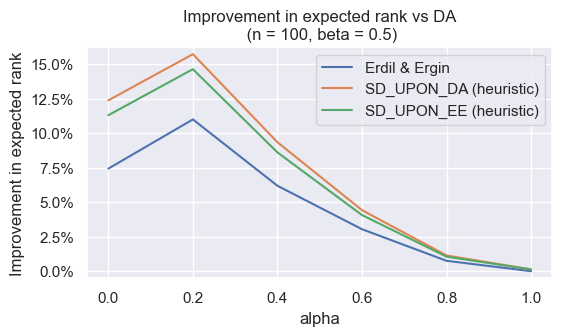

In [ ]:
SimulationsEvaluate("SIM_2025-07-29_115642", False)

    x  bar_value  line_value
0   1   4.405579    0.869304
1   2   1.318106    0.135648
2   3   7.132610    0.248829
3   4   6.338605    0.855828
4   5   2.630714    0.350099
5   6   7.197983    0.250332
6   7   7.661820    0.435351
7   8   1.547008    0.296369
8   9   3.574242    0.460080
9  10   6.549910    0.015991


KeyError: 'bar_percent'

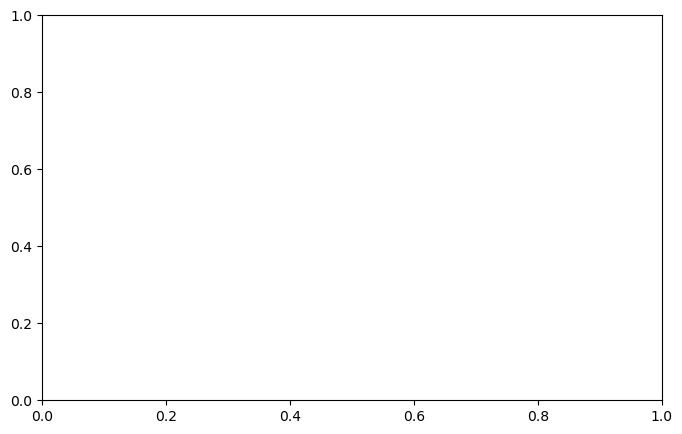

In [ ]:
# Example DataFrame
df = pd.DataFrame({
    'x': range(1, 11),
    'bar_value': np.random.uniform(0, 10, 10),
    'line_value': np.random.uniform(0, 1, 10)  # already in percentage form (0–1)
})
print(df)

# Convert both to percentages
df['bar_percent'] = 100 * df['bar_value'] / 10   # since bar_value ranges 0–10
df['line_percent'] = 100 * df['line_value']      # since line_value ranges 0–1

# Plot both on same axis
fig, ax = plt.subplots(figsize=(8, 5))

# Bar plot
ax.bar(df['x'], df['bar_percent'], color='skyblue', alpha=0.6, label='Bar value (%)')

# Line plot
ax.plot(df['x'], df['line_percent'], color='orange', marker='o', linewidth=2, label='Line value (%)')

# Axis formatting
ax.set_xlabel('Observation')
ax.set_ylabel('Percentage (%)')
ax.set_ylim(0, 100)
ax.set_xticks(df['x'])
ax.legend()
plt.title('Bars and Line on Same Percentage Scale')

plt.tight_layout()
plt.show()


In [ ]:
for k in range(5):
    print(k)

0
1
2
3
4


In [ ]:
A = [[0,1],[1,0]]
B = [[0,1],[1,0]]
C = [[0,1],[1,1]]

print(A == B)
print(A == C)

True
False
